# Nitrogen thresholds into Acidification Potential Thresholds
This translates each ecoreigon threshold into an acidification potential threshold. It divides total nitrogen deposition into NH3 and NOx, calculate average for each ecoregion, and divides the threshold according to that average. It then apply each LEAF into it and voila

## Nitrogen breakdown

In [2]:
import polars as pl
import geopandas as gpd
import sbtn_leaf.map_plotting as mplot
import sbtn_leaf.map_calculations as mc


Could not determine dtype for column 1, falling back to string


Select needed files for 2020


In [3]:
tot_NOy_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNOy_2020_hm.tif"
tot_NHx_fp = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNHx_2020_hm.tif"
tot_N_fp   = "../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif"

Checking total N depositions

In [4]:
mplot.inspect_raster(tot_N_fp)

File: ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif
Driver: GTiff
Width, Height: 2307, 1430
Number of Bands: 1
CRS: PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",105],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",47],PARAMETER["false_easting",4000000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-12754690.136988254, bottom=-4121276.274192298, right=20764251.306624927, top=16655527.481493374)
Pixel Size: (14529.233395584386, 14529.233395584386)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
DataType: Generic
AREA

Raster has 475,006 unique values. Min: 0.00. Max: 67.28
Using quantiles
All positives route (quantiles)


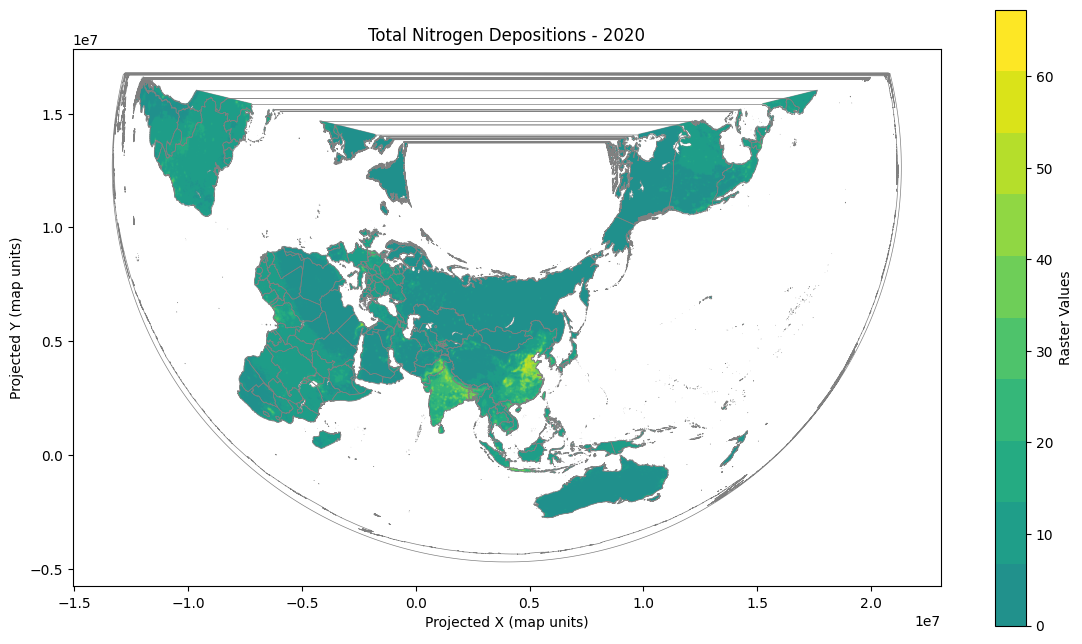

In [6]:
mplot.plot_raster_on_world_extremes_cutoff(tot_N_fp, "Total Nitrogen Depositions - 2020", perc_cutoff=0, quantiles=10)

Transforming

In [13]:
tot_N_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_N_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_N",
    area_type="ecoregion"
)

2025-11-14 17:24:46,549 - INFO - Starting: Calculating ecoregion weighted CF for tot_N without outlier filtering
2025-11-14 17:26:57,432 - INFO - Calculations complete for ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totN_2020_hm.tif! Found matches for 779 regions.



In [14]:
tot_NHx_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NHx_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NHx",
    area_type="ecoregion"
)

2025-11-14 17:26:57,478 - INFO - Starting: Calculating ecoregion weighted CF for tot_NHx without outlier filtering
2025-11-14 17:29:47,676 - INFO - Calculations complete for ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNHx_2020_hm.tif! Found matches for 779 regions.



In [15]:
tot_NOy_er_results = mc.calculate_area_weighted_cfs_from_raster_with_std_and_median_vOutliers(
    raster_input_filepath=tot_NOy_fp,
    cf_name="N depositions",
    cf_unit="kg N/ha",
    flow_name="tot_NOy",
    area_type="ecoregion"
)

2025-11-14 17:29:47,715 - INFO - Starting: Calculating ecoregion weighted CF for tot_NOy without outlier filtering
2025-11-14 17:32:30,608 - INFO - Calculations complete for ../thresholds/Global_N_deposition_grid_dataset_2008_2020/mean_totNOy_2020_hm.tif! Found matches for 779 regions.



In [16]:
tot_N_er_gdf = tot_N_er_results[1]

<Axes: >

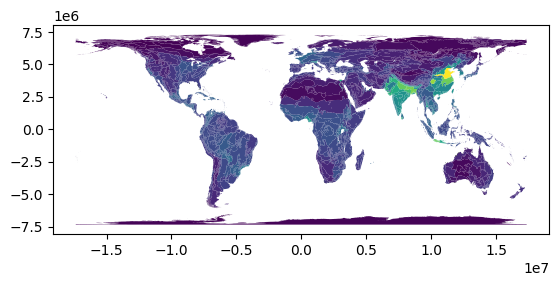

In [17]:
tot_N_er_gdf.plot(column = "cf")